# Part 1: Data Preprocessing and Exploration

This final project is based around the [Open Psychometrics "Which Character" Quiz](https://openpsychometrics.org/tests/characters/documentation/). The quiz follows a standard internet format: Respondents assess themselves on series of opposed traits (e.g., are you more selfish or altruistic?), and at the end of the quiz, they are presented with their most similar fictional character (e.g., Batman or Buffy the Vampire Slayer). After the quiz has been completed, users are invited to rate the personalities of the characters themselves (e.g., is Batman more altruistic or selfish?). Open Psychometrics researchers have aggregated the ratings of 2,125 characters across 500 dimensions on a 100-point scale. The aggregate ratings are based on 3,386,031 user responses. Our work is inspired by the work of the [Vermont Computational Story Lab](https://compstorylab.org/archetypometrics/).

In this first notebook, we'll import, clean, and prepare the data for exploration. We'll conduct light exploration to assess the contents of the data. The dataset `characters-aggregated-scores.csv` was downloaded from [Open Psychometrics](https://openpsychometrics.org/tests/characters/data/). Supplemental datasets (to provide variable and character names) were developed based on the online documentation, which is available here as an `.html` file in the `data` folder. _Note: If downloading an updated version of the dataset, the data formats, character names, and variables might have changed._

### Imports

In [4]:
# importing data libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
import random

# Custom installable package
import finaltools as ft

### Reading the Data

In [5]:
# reading in the characters-aggregated-scores.csv, variable-key.csv, character-key.csv from the data folder
char_score_data = pd.read_csv("data/characters-aggregated-scores.csv", sep=",")
var_key = pd.read_csv("data/variable-key.csv")
char_key = pd.read_csv("data/character-key.csv")

### Looking at the Data

First, we'll start by looking at the 3 main data sources, examining their shapes, and data types.

In [5]:
# here is modularized function for this section:
'''
def initial_data_look(data):
    print("Here are the first 5 rows of the data:")
    display(data.head())
    print("---------------------------------------------------------")
    print("The number of rows and columns in this dataset are", data.shape)
    print("---------------------------------------------------------")
    print("Here are the data types of each of the columns:")
    display(data.info())
    print("---------------------------------------------------------")
    print("Checking if there are any missing values:", np.mean(data.isna()))
'''

'\ndef initial_data_look(data):\n    print("Here are the first 5 rows of the data:")\n    display(data.head())\n    print("---------------------------------------------------------")\n    print("The number of rows and columns in this dataset are", data.shape)\n    print("---------------------------------------------------------")\n    print("Here are the data types of each of the columns:")\n    display(data.info())\n    print("---------------------------------------------------------")\n    print("Checking if there are any missing values:", np.mean(data.isna()))\n'

In [6]:
# start with characters-aggregated-scores.csv
ft.initial_data_look(char_score_data)

Here are the first 5 rows of the data:


,id,BAP1,BAP2,BAP3,BAP4,BAP5,BAP6,BAP7,BAP8,BAP9,...,BAP491,BAP492,BAP493,BAP494,BAP495,BAP496,BAP497,BAP498,BAP499,BAP500
0,HML/1,62.4,69.8,92.6,31.9,61.2,53.5,28.8,44.0,63.9,...,27.5,78.8,40.5,53.4,77.4,14.0,56.3,51.4,87.4,8.2
1,HML/2,79.1,62.2,68.5,78.1,36.9,40.3,42.6,40.4,23.3,...,42.8,23.9,84.9,73.7,49.0,73.7,21.1,71.0,26.3,63.3
2,HML/3,83.2,85.3,69.4,21.8,39.1,35.8,49.9,16.0,59.3,...,11.3,29.7,50.7,78.6,68.2,20.3,31.6,48.7,74.3,55.0
3,HML/4,72.5,65.0,67.1,28.2,66.3,47.9,30.4,18.1,34.4,...,31.6,22.2,75.7,60.4,79.0,55.9,25.5,48.2,80.1,49.6
4,HML/5,40.7,48.1,81.8,90.0,52.6,59.3,41.1,73.9,43.0,...,35.6,42.4,75.0,61.7,61.3,15.1,57.3,54.7,90.3,24.9


---------------------------------------------------------
The number of rows and columns in this dataset are (2125, 501)
---------------------------------------------------------
Here are the data types of each of the columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2125 entries, 0 to 2124
Columns: 501 entries, id to BAP500
dtypes: float64(500), object(1)
memory usage: 8.1+ MB


None

---------------------------------------------------------
Checking if there are any missing values: 0.0


In [5]:
# explore variable-key.csv
ft.initial_data_look(var_key)

Here are the first 5 rows of the data:


,ID,scale
0,BAP1,playful_serious
1,BAP2,shy_bold
2,BAP3,cheery_sorrowful
3,BAP4,masculine_feminine
4,BAP5,charming_awkward


---------------------------------------------------------
The number of rows and columns in this dataset are (500, 2)
---------------------------------------------------------
Here are the data types of each of the columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      500 non-null    object
 1   scale   500 non-null    object
dtypes: object(2)
memory usage: 7.9+ KB


None

---------------------------------------------------------
Checking if there are any missing values: 0.0


In [6]:
# explore character-key.csv
ft.initial_data_look(char_key)

Here are the first 5 rows of the data:


,id,name,source
0,HML/1,Prince Hamlet,Hamlet
1,HML/2,Queen Gertrude,Hamlet
2,HML/3,King Claudius,Hamlet
3,HML/4,Polonius,Hamlet
4,HML/5,Ophelia,Hamlet


---------------------------------------------------------
The number of rows and columns in this dataset are (2125, 3)
---------------------------------------------------------
Here are the data types of each of the columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2125 entries, 0 to 2124
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2125 non-null   object
 1   name    2125 non-null   object
 2   source  2125 non-null   object
dtypes: object(3)
memory usage: 49.9+ KB


None

---------------------------------------------------------
Checking if there are any missing values: 0.0


By taking an initial look at the data, it aligns with the Open Psychometrics Quiz information. We see that for `characters-aggregated-scores.csv`, there are 2125 rows, 501 columns (which include an id column which is an object data type and BAP# ratings from 1-100), and no missing values. The `variable-key.csv` data set provides information about what the BAP# columns correspond to in terms of adjective pairs for the ratings. The `character-key.csv` provides information on the `id` column relating each row to the character and movie/novel source for that character.

The columns represent each dimension on which the characters were rated—or "binary adjective pairs" (BAPs). We'll make these more legible using our `var_key` and provide actual names for the characters. We rename the columns based on the `var_key`, and then we drop a few specific columns: The authors used emojis for some of the BAPs, which are hard to interpret and cause problems with visualization, so they have been labeled "INVALID." In addition, the authors accidentally included the "hard-soft" pair twice, so only the first pair is kept.

In [7]:
# merge character names and source from char_key to char_score_data
char_score_data = pd.merge(char_key, char_score_data, on="id")

# rename columns for readability
char_score_data.columns = ["id"] + ["character"] + ["source"] + var_key["scale"].to_list() 

# omit 'INVALID' keys with emojis in their BAP names
char_score_data = char_score_data.loc[:,~char_score_data.columns.str.startswith('INVALID')]

# remove duplicated column names/BAPs
char_score_data = char_score_data.loc[:, ~char_score_data.columns.duplicated()]

In the datafame below, the low end of the 100-point scale correspond to left-hand "adjective", and vice versa.

In [8]:
# take another look at characters-aggregated-scores.csv after cleaning above
ft.initial_data_look(char_score_data)

Here are the first 5 rows of the data:


,id,character,source,playful_serious,shy_bold,cheery_sorrowful,masculine_feminine,charming_awkward,lewd_tasteful,intellectual_physical,...,cringing-away_welcoming-experience,stereotypical_boundary-breaking,energetic_mellow,hopeful_fearful,likes-change_resists-change,manic_mild,old-fashioned_progressive,gross_hygienic,stable_unstable,overthinker_underthinker
0,HML/1,Prince Hamlet,Hamlet,62.4,69.8,92.6,31.9,61.2,53.5,28.8,...,27.5,78.8,40.5,53.4,77.4,14.0,56.3,51.4,87.4,8.2
1,HML/2,Queen Gertrude,Hamlet,79.1,62.2,68.5,78.1,36.9,40.3,42.6,...,42.8,23.9,84.9,73.7,49.0,73.7,21.1,71.0,26.3,63.3
2,HML/3,King Claudius,Hamlet,83.2,85.3,69.4,21.8,39.1,35.8,49.9,...,11.3,29.7,50.7,78.6,68.2,20.3,31.6,48.7,74.3,55.0
3,HML/4,Polonius,Hamlet,72.5,65.0,67.1,28.2,66.3,47.9,30.4,...,31.6,22.2,75.7,60.4,79.0,55.9,25.5,48.2,80.1,49.6
4,HML/5,Ophelia,Hamlet,40.7,48.1,81.8,90.0,52.6,59.3,41.1,...,35.6,42.4,75.0,61.7,61.3,15.1,57.3,54.7,90.3,24.9


---------------------------------------------------------
The number of rows and columns in this dataset are (2125, 467)
---------------------------------------------------------
Here are the data types of each of the columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2125 entries, 0 to 2124
Columns: 467 entries, id to overthinker_underthinker
dtypes: float64(464), object(3)
memory usage: 7.6+ MB


None

---------------------------------------------------------
Checking if there are any missing values: 0.0


After cleaning up the `char_score_data`, there are more readable column names with the BAPs being the names of the adjective pairs. It is also clear which characters and sources each `id` corresponds to. Another big change to note is that there are still the same number of rows because there are no missing values, but there is now 464 BAP columns rather than 500 after removing duplicates and `INVALID` entries. 

In [9]:
# save the processed char_score_data in the data/processed folder

# make sure the folder exists
os.makedirs("data/processed", exist_ok=True)

# save as CSV
char_score_data.to_csv("data/processed/char_score_data.csv", index=False)

### Data Exploration

#### Most Right vs. Most Left BAPs

What if we want to know the 10 most charming and awkward characters in the dataset? The functions below allow you to input the data and the name of the column you're most interested in. `most_right()` will print the highest scores for the right-hand term, while `most_left()` will print the highest scores for the left-hand term (which are technically the lowest scores on that dimension).

In [12]:
'''
def most_right(data, column_name):
    most_right = data.nlargest(n=10, columns=[column_name])
    most_right = most_right[["character", "source", column_name]]
    print(most_right)

def most_left(data, column_name):
    most_right = data.nsmallest(n=10, columns=[column_name])
    most_right = most_right[["character", "source", column_name]]
    print(most_right)
'''

'\ndef most_right(data, column_name):\n    most_right = data.nlargest(n=10, columns=[column_name])\n    most_right = most_right[["character", "source", column_name]]\n    print(most_right)\n\ndef most_left(data, column_name):\n    most_right = data.nsmallest(n=10, columns=[column_name])\n    most_right = most_right[["character", "source", column_name]]\n    print(most_right)\n'

In [10]:
ft.most_right(char_score_data, "charming_awkward")

                character                        source  charming_awkward
816        Emma Pillsbury                          Glee              93.1
1264  Mr. William Collins           Pride and Prejudice              93.0
762          Tina Belcher                 Bob's Burgers              92.2
1016         Kirk Gleason                 Gilmore Girls              91.7
2063         Buster Bluth          Arrested Development              91.6
909          Stuart Bloom           The Big Bang Theory              91.4
1324                James  The End of the F***ing World              91.3
345            Jonah Ryan                          Veep              90.8
2064         Tobias Funke          Arrested Development              90.8
672           Morty Smith                Rick and Morty              90.6


In [11]:
ft.most_left(char_score_data, "charming_awkward")

                character                source  charming_awkward
1142         Neal Caffrey          White Collar               3.1
2092           James Bond  Tommorrow Never Dies               4.4
248           Inara Serra    Firefly + Serenity               4.8
556   Lucifer Morningstar               Lucifer               6.4
1223       Frank Abagnale   Catch Me If You Can               6.5
203            Don Draper               Mad Men               6.7
1534      Damon Salvatore   The Vampire Diaries               6.8
1545             Lagertha               Vikings               6.9
207         Joan Holloway               Mad Men               7.4
63         Derek Shepherd        Grey's Anatomy               7.7


It is quite interesting that Emma Pillsbury from Glee is rated the most awkward character vs. Neal Caffrey is rated as the most charming.

#### Scores with Highest/Lowest Averages

Now let's turn to exploring the Highest and Lowest averages for each character and also for BAP.

In [12]:
# look at average_rankings ACROSS all BAPs for a 
char_score_data["average_rankings"] =  char_score_data.iloc[:, 3:465].mean(axis=1)
'''
def explore_bap_averages(data, groups=False):
    # complete dataset aggregation for a simple overview
    if not groups:
        overall_min = data["average_rankings"].min()
        overall_max = data["average_rankings"].max()

        return data.loc[
            (data["average_rankings"] == overall_min) |
            (data["average_rankings"] == overall_max),
            ["character", "source", "average_rankings"]
        ]

    # intermediate function to help with group-wise operations
    def summarize_group(df):
        min_idx = df["average_rankings"].idxmin()
        max_idx = df["average_rankings"].idxmax()

        return pd.Series({
            "num_characters": df["character"].nunique(),
            "min_character": df.loc[min_idx, "character"],
            "min_ranking": df.loc[min_idx, "average_rankings"],
            "max_character": df.loc[max_idx, "character"],
            "max_ranking": df.loc[max_idx, "average_rankings"],
            "avg_average_rankings": df["average_rankings"].mean(),
            "std_average_rankings": df["average_rankings"].std()
        })

    return (
        data
        .groupby("source", as_index=False)
        .apply(summarize_group, include_groups=False)
        .sort_values("num_characters", ascending=False)
        .reset_index(drop=True)
    )
'''

'\ndef explore_bap_averages(data, groups=False):\n    # complete dataset aggregation for a simple overview\n    if not groups:\n        overall_min = data["average_rankings"].min()\n        overall_max = data["average_rankings"].max()\n\n        return data.loc[\n            (data["average_rankings"] == overall_min) |\n            (data["average_rankings"] == overall_max),\n            ["character", "source", "average_rankings"]\n        ]\n\n    # intermediate function to help with group-wise operations\n    def summarize_group(df):\n        min_idx = df["average_rankings"].idxmin()\n        max_idx = df["average_rankings"].idxmax()\n\n        return pd.Series({\n            "num_characters": df["character"].nunique(),\n            "min_character": df.loc[min_idx, "character"],\n            "min_ranking": df.loc[min_idx, "average_rankings"],\n            "max_character": df.loc[max_idx, "character"],\n            "max_ranking": df.loc[max_idx, "average_rankings"],\n            "avg_av

In [13]:
# explore overall min and max rankings
ft.explore_bap_averages(char_score_data, groups = False)

,character,source,average_rankings
1495,Cyril Figgis,Archer,53.890693
1549,Ragnar Lothbrok,Vikings,46.743506


In [14]:
# explore group ("source")-wise rankings and EDA
ft.explore_bap_averages(char_score_data, groups = True).head(10)

,source,num_characters,min_character,min_ranking,max_character,max_ranking,avg_average_rankings,std_average_rankings
0,Game of Thrones,30,Oberyn Martell,47.155628,Theon Greyjoy,52.688745,49.776378,1.523506
1,The Wire,30,Omar Little,47.477273,Maurice Levy,52.454545,49.951638,1.031501
2,Harry Potter,30,Nymphadora Tonks,47.616883,Petunia Dursley,53.436364,50.231046,1.313676
3,Stranger Things,15,Max Mayfield,48.366017,Will Byers,51.772294,49.963579,1.110399
4,LOST,15,John Locke,48.469481,Shannon Rutherford,51.381169,49.976306,0.786228
5,Ginny & Georgia,15,Georgia Miller,47.477922,Nick Throop,51.832684,50.492006,1.133693
6,Star Trek: Deep Space Nine,15,Jadzia Dax,48.152165,Rom,51.696753,49.735079,1.106190
7,Downton Abbey,15,Lady Sybil Crawley,47.701299,William Mason,51.595887,50.234848,1.071705
8,Mad Men,15,Joan Holloway,47.658874,Lane Pryce,51.876190,50.018369,1.154706
9,The Boys,15,Billy Butcher,48.552381,Becca Butcher,52.109307,50.133247,1.217897


It looks like overall the `average_rankings` across all the characters range from roughly 46 to 54, which makes sense that there isn't much variation because all 462 binary adjective pairs (BAPs) cancel each other out at some point. Also, it's important to note that on it's own the `average_rankings` isn't fully interpretable. Let's look at BAP/column-wise averages instead.

In [15]:
# see the column-wise means for all the BAPs
bap_averages = char_score_data.iloc[:, 3:465].mean(axis=0).sort_values(ascending=False)
bap_averages

unambitious_driven       73.320988
neutral_opinionated      70.997647
shy_bold                 70.918071
androgynous_gendered     70.769129
racist_egalitarian       69.652188
                           ...    
important_irrelevant     31.140424
devoted_unfaithful       30.839200
diligent_lazy            27.569694
motivated_unmotivated    26.370776
persistent_quitter       23.118024
Length: 462, dtype: float64

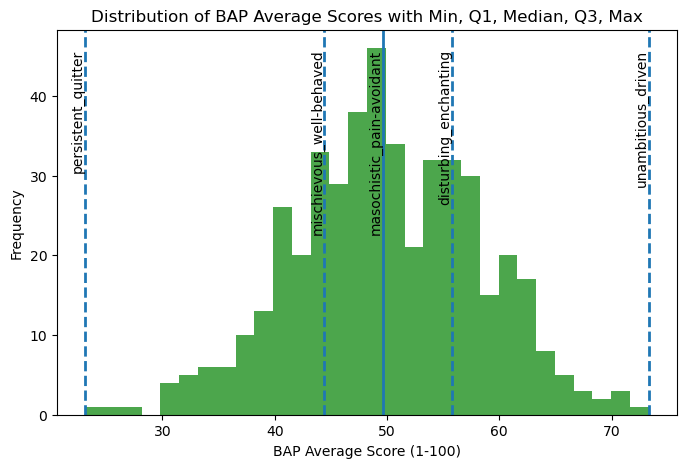

In [16]:
# see a histogram of the bap_averages

s = bap_averages

# calculate summary statistics
min_val = s.min()
q1_val = s.quantile(0.25)
median_val = s.quantile(0.50)
q3_val = s.quantile(0.75)
max_val = s.max()

# corresponding indices
min_idx = s.idxmin()
max_idx = s.idxmax()
q1_idx = (s - q1_val).abs().idxmin()
median_idx = (s - median_val).abs().idxmin()
q3_idx = (s - q3_val).abs().idxmin()

# plot the histogram
plt.figure(figsize=(8, 5))
plt.hist(s.values, bins=30, alpha=0.7, color = "green")

# plot vertical lines
plt.axvline(min_val, linestyle="--", linewidth=2)
plt.axvline(q1_val, linestyle="--", linewidth=2)
plt.axvline(median_val, linestyle="-", linewidth=2)
plt.axvline(q3_val, linestyle="--", linewidth=2)
plt.axvline(max_val, linestyle="--", linewidth=2)

# create annotations
ymax = plt.ylim()[1]

plt.text(min_val, ymax * 0.95, f"{min_idx}", rotation=90, va="top", ha="right")
plt.text(q1_val, ymax * 0.95, f"{q1_idx}", rotation=90, va="top", ha="right")
plt.text(median_val, ymax * 0.95, f"{median_idx}", rotation=90, va="top", ha="right")
plt.text(q3_val, ymax * 0.95, f"{q3_idx}", rotation=90, va="top", ha="right")
plt.text(max_val, ymax * 0.95, f"{max_idx}", rotation=90, va="top", ha="right")

# make labels
plt.xlabel("BAP Average Score (1-100)")
plt.ylabel("Frequency")
plt.title("Distribution of BAP Average Scores with Min, Q1, Median, Q3, Max")

# create a visualizations folder to save this visualization if it doesn't exist
os.makedirs("visualizations", exist_ok=True)

# save the figure as bap_averages_histogram.png
plt.savefig("visualizations/bap_averages_histogram.png", dpi=300, bbox_inches="tight")

plt.show()

For “unambitious_driven,” the average ratings are skewed toward driven, suggesting that characters are generally perceived as driven rather than unambitious. In contrast, “persistent_quitter” shows ratings concentrated closer to persistent, indicating that characters are more often characterized as persistent than as quitters. Together, these patterns suggest that in movie character development, traits such as being driven and persistent are more commonly emphasized or recognized by viewers than their opposing traits.

In [17]:
# now let's look at the standard deviations
bap_std = char_score_data.iloc[:, 3:465].std(axis=0).sort_values(ascending=False)
bap_std

masculine_feminine               27.308177
main-character_side-character    25.364726
hugs_handshakes                  25.029397
parental_childlike               24.895246
sporty_bookish                   24.396562
                                   ...    
libertarian_socialist            10.879973
Greek_Roman                      10.848932
Coke_Pepsi                       10.646473
tautology_oxymoron                9.480700
right-brained_left-brained        6.735486
Length: 462, dtype: float64

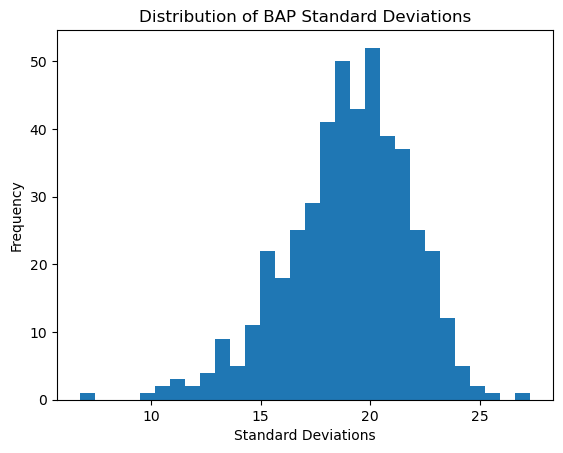

In [18]:
# plot a histogram of the standard deviations
plt.hist(bap_std, bins = 30)

# add labels and title
plt.title("Distribution of BAP Standard Deviations")
plt.xlabel("Standard Deviations")
plt.ylabel("Frequency")

# save the figure as bap_averages_histogram.png
plt.savefig("visualizations/bap_std_histogram.png", dpi=300, bbox_inches="tight")

# show the plot
plt.show()

The BAP ratings seem to vary from their means as much as approximately 28 scores to about 6. While on average they seem to vary close to about 20 scores. BAPs like "right-brained left-brained" or "Coke Pepsi" might not be very hard to discern characters that are on the polar opposites since they aren't very intuitive as to what a more right-brained person looks like or a more "Coke" person is. On the other hand, for BAPs like "masculine feminine" or "parental childlike", it is clearer and more intuitive to understand what more female than male means or what being more of a main character than side character looks like.

#### Correlation Matrices

Now let's explore correlation matrices between the BAP columns for a better understanding for the data before PCA.

In [19]:
# lets take another look at the BAP columns
char_score_data.iloc[:, 3:465].columns

Index(['playful_serious', 'shy_bold', 'cheery_sorrowful', 'masculine_feminine',
       'charming_awkward', 'lewd_tasteful', 'intellectual_physical',
       'strict_lenient', 'refined_rugged', 'trusting_suspicious',
       ...
       'sincere_irreverent', 'intuitive_analytical',
       'cringing-away_welcoming-experience', 'stereotypical_boundary-breaking',
       'energetic_mellow', 'hopeful_fearful', 'likes-change_resists-change',
       'manic_mild', 'old-fashioned_progressive', 'gross_hygienic'],
      dtype='object', length=462)

In [20]:
# available columns
columns = char_score_data.iloc[:, 3:465].columns.tolist()

# widget for selecting 10 columns
column_selector = widgets.SelectMultiple(
    options=columns,
    value=columns[:10],   # default selection is the first 10
    description='Traits',
    disabled=False
)

# function to update the heatmap
'''
def update_correlation(selected_columns, data, all_columns, default_n=10):
    if not selected_columns:
        return

    subset = data[list(selected_columns)]
    corr = subset.corr().round(2)

    fig = px.imshow(
        corr,
        text_auto=True,
        color_continuous_scale="RdBu",
        zmin=-1, zmax=1,
        title="Correlation Matrix of Selected BAPs"
    )
    fig.update_layout(width=700, height=700)
    fig.show()

    if tuple(selected_columns) == tuple(all_columns[:default_n]):
        fig.write_html("visualizations/default_correlation_map.html")
        

def correlation_interactive(char_score_data, col_slice=slice(3, 465), default_n=10,
                         save="visualizations/default_correlation_map.html"):
    columns = char_score_data.iloc[:, col_slice].columns.tolist()

    column_selector = widgets.SelectMultiple(
        options=columns,
        value=tuple(columns[:default_n]),
        description="Traits",
        disabled=False
    )

    widgets.interact(
        update_correlation,
        selected_columns = column_selector,
        data = widgets.fixed(char_score_data),
        all_columns = widgets.fixed(columns),
        save_default_to = widgets.fixed(save),
        default_n = widgets.fixed(default_n),
    )
'''
# interactive display
ft.interactive_correlation(char_score_data)

interactive(children=(SelectMultiple(description='Traits', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), options=('pla…

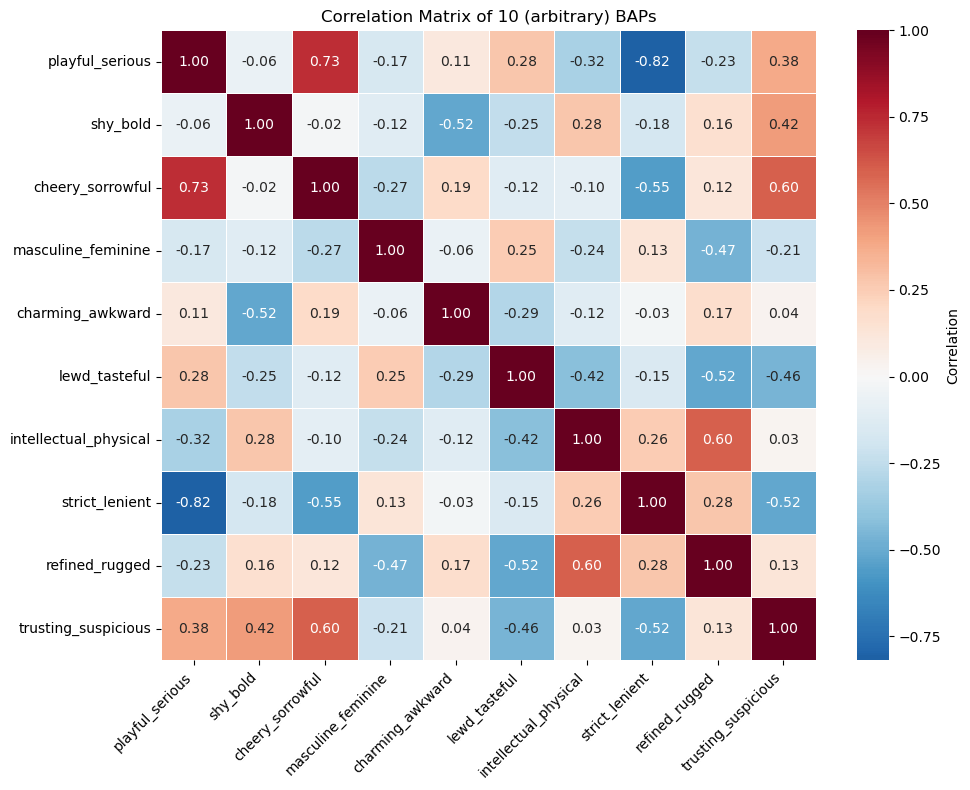

In [21]:
# display a static version of the chart below (so it's viewable on GitHub as well)
# fixed 10 columns (similar to above)
static_columns = columns[:10]

# subset the data with chosen columns
subset = char_score_data[static_columns]
corr = subset.corr().round(2)

# plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,           # show correlation values
    fmt=".2f",            # round to 2 decimals
    cmap="RdBu_r",        # diverging red–blue
    center=0,             # center the colormap at 0
    linewidths=0.5,
    cbar_kws={'label': 'Correlation'}
)

# customize axis labels and title
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title("Correlation Matrix of 10 (arbitrary) BAPs")
plt.tight_layout()
plt.savefig("visualizations/default_correlation_map.png", dpi=300, bbox_inches="tight")

# Show plot
plt.show()

In the correlation matrix above, there are some variables that are very strongly correlated like playful_serious and strict_lenient are strongly negatively correlated (assuming they have a linear relationship). This makes sense because people who are more playful are likely also lenient while those who are serious are strict. There are also a lot of close to uncorrelated variables like trusting_suspicious and intellectual_physical where they don't seem to be related in a certain way.

#### Group by Source Visualization

In [22]:
# lets look at the 10 largest groups of the sources
top_10_sources = char_score_data["source"].value_counts().head(10).index
top_10_sources

Index(['Game of Thrones', 'The Wire', 'Harry Potter', 'Westworld',
       'The Simpsons', 'Stranger Things', 'Glee', 'LOST', 'Mad Men',
       'Marvel Cinematic Universe'],
      dtype='object', name='source')

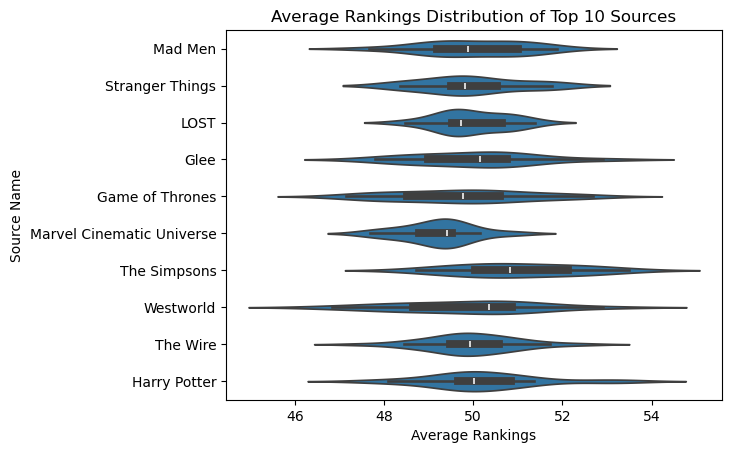

In [23]:
# graph the distribution of average rankings by source name

# update the dataframe to include the top 10 sources
top_10_source_df = char_score_data[char_score_data["source"].isin(top_10_sources)]

# plot it as a violinplot
sns.violinplot(data = top_10_source_df, y = "source", x = "average_rankings")
plt.title("Average Rankings Distribution of Top 10 Sources")
plt.xlabel("Average Rankings")
plt.ylabel("Source Name")

# save the figure output
plt.savefig("visualizations/average_rankings_for_top10_sources.png", dpi=300, bbox_inches="tight")

# show the plot
plt.show()

Here is the average rankings distribution for the top 10 sources or media sources with the most number of characters. While the average rankings roughly center around 50, characters in the Marvel Cinematic Universe have, on average, slightly lower ratings than average, while Westworld characters have higher ratings than the average.